In [1]:
import os
import numpy as np
import xarray as xr

import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

import cartopy
import cartopy.crs as ccrs
#import cartopy.feature as cfeature
#from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
cartopy.config['data_dir'] = os.getenv('CARTOPY_DIR', cartopy.config.get('data_dir'))

import cmocean

In [2]:
# For the bio dataset
base_url = "http://thredds.ereefs.aims.gov.au/thredds/dodsC/s3://aims-ereefs-public-prod/derived/ncaggregate/ereefs/GBR4_H2p0_B3p1_Cq3b_Dhnd/daily-monthly/EREEFS_AIMS-CSIRO_GBR4_H2p0_B3p1_Cq3b_Dhnd_bgc_daily-monthly-"

# For the hydro dataset
base_url2 = "http://thredds.ereefs.aims.gov.au/thredds/dodsC/s3://aims-ereefs-public-prod/derived/ncaggregate/ereefs/gbr4_v2/daily-monthly/EREEFS_AIMS-CSIRO_gbr4_v2_hydro_daily-monthly-"

In [3]:
month_st = 1   # Starting month 
month_ed = 1   # Ending month 
year = 2018    # Year

# Based on the server the file naming convention 
biofiles = [f"{base_url}{year}-{month:02}.nc" for month in range(month_st, month_ed+1)]
hydrofiles = [f"{base_url2}{year}-{month:02}.nc" for month in range(month_st, month_ed+1)]

Show the area that we are focusing on

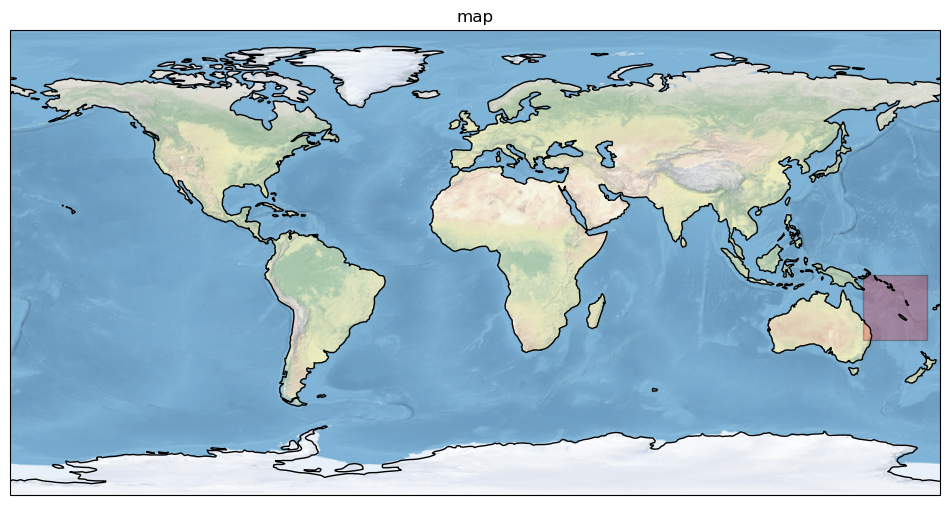

In [43]:
#extent = [np.min(ds.longitude),np.max(ds.longitude),np.min(ds.latitude),np.max(ds.latitude)]
#central_lon = np.mean(extent[:2])
#central_lat = np.mean(extent[2:])

fig0 = plt.figure(figsize=(12,12))
central_lon = 150 #TODO
ax0 = fig0.add_subplot(111,projection=ccrs.PlateCarree())
ax0.stock_img()
ax0.coastlines()
ax0.set_title('map')
ax0.add_patch(mpatches.Rectangle(xy=[150, -30], width=25, height=25, #TODO
                                    facecolor='red',
                                    edgecolor='k',
                                    alpha=0.25,
                                    transform=ccrs.PlateCarree()))
plt.show()
